In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *
from Utils.preprocessing import *

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import plotly.express as px

from itertools import combinations
import warnings

sns.set(font="monospace")
warnings.filterwarnings('ignore')
RANDOM_STATE = 632

# Load Data

In [2]:
# Load the dataset
file_path = 'Data/Analyst_Coverage.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.sample(15)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
5915,Jonqvist,1/29/2020,Inres,1.0,sell,42.00,ELISA FH Equity,Communication Services,Telecommunication Services
7112,Yi Zhong,3/5/2020,Alope,5.0,buy,45.00,AC FP Equity,Consumer Discretionary,Consumer Services
8525,Denolina,3/6/2020,MoInc,5.0,buy,12.60,TKA GR Equity,Materials,Materials
1329,Trianson,3/3/2020,Exbas,3.0,neutral,150.00,SAF FP Equity,Industrials,Capital Goods
3686,Micel Wu,3/1/2020,MoInc,5.0,buy,804.34,STAN LN Equity,Financials,Banks
7108,Timnonen,10/3/2019,Haken,3.0,hold,200.00,ALFA SS Equity,Industrials,Capital Goods
5272,Jonqvist,1/30/2020,Inres,2.0,reduce,42.00,TELIA SS Equity,Communication Services,Telecommunication Services
8381,Betscher,10/5/2016,Laerg,3.0,hold,33.00,PROX BB Equity,Communication Services,Telecommunication Services
6237,Monllard,3/6/2020,Ciiti,1.0,sell,7050.00,FLTRL EB Equity,Consumer Discretionary,Consumer Services
2301,Ioatikis,2/27/2020,MoInc,3.0,hold,21.00,AD NA Equity,Consumer Staples,Food & Staples Retailing


Course project 3

○ Building an unsupervised model to cluster stocks, modeling covariance/distance matrix structures

○ Understanding how companies/stocks are grouped together and investigate better ways of recategorizing peer groups

GICS industry code (8 digits) consists of:

11 sectors, 24 industry groups, 69 industries and 158 sub-industries

(sector | industry group | industry | sub-industry)

# Data Preprocessing
- Check for NA values
- Check for duplicates
- Standardise row types


In [3]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()
# Check Types
print(df.info())

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-

We will impute the NaN values for ratings with the mean ratings per industry

In [4]:
df_mean_rating = df[["GICS_SECTOR_NAME", "RATING"]].dropna().groupby(["GICS_SECTOR_NAME"], as_index=False).mean()
df_imputed = df[df["RATING"].isna()].copy()
df_imputed = df_imputed.drop(columns=["RATING"]).merge(df_mean_rating, on=["GICS_SECTOR_NAME"])
df_clean = pd.concat([df.dropna(), df_imputed])

print(df_clean.shape)
df_clean.sample(7)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
1484,NicPalma,3/6/2020,Exbas,5.0,outperform,1920.0,PRU LN Equity,Financials,Insurance
2088,Pao Citi,3/4/2020,Innte,3.0,neutral,13.0,ENI IM Equity,Energy,Energy
5821,Handniok,2/27/2020,Alope,4.0,add,65.5,PAH3 GR Equity,Consumer Discretionary,Automobiles & Components
3142,PetEliot,3/4/2020,Keeux,3.0,hold,18.9,G IM Equity,Financials,Insurance
657,Andkhnin,2/10/2020,Crsse,5.0,outperform,145.0,SIE GR Equity,Industrials,Capital Goods
3713,Danliffe,3/4/2020,Lirum,1.0,sell,116.0,SAND SS Equity,Industrials,Capital Goods
7476,SanBunck,3/5/2020,Baays,1.0,underweight,460.0,BLND LN Equity,Real Estate,Real Estate


# Analyze Data


## 1. Which company has the higher analyst coverage?

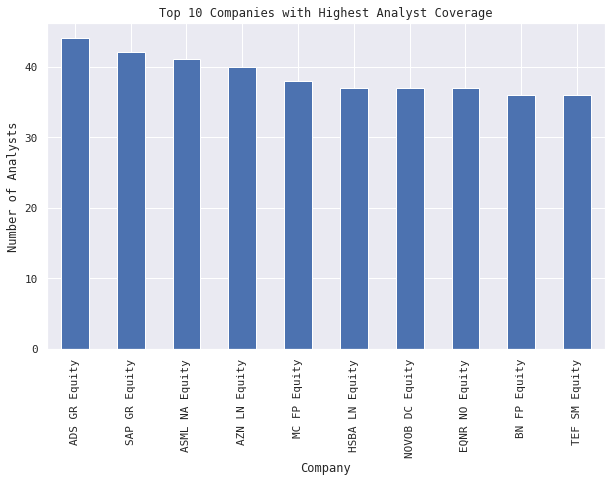

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [5]:
# Calculate the analyst coverage for each company
df_coverage = df_clean[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='bar')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

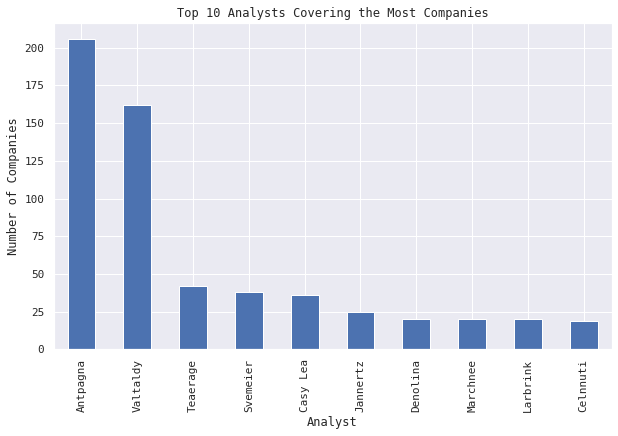

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [6]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='bar')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")


## 3. Similarity Matrix
https://medium.com/analytics-vidhya/similarity-measures-for-categorical-data-d83a1812bbe9

Based on how analysts organize themselves into covering companies,
### a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


In [7]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'BROKER']
numerical_features = ['RATING']
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# We only want to observe analyst 'Antpagna'
# We also clean the dataset 
## -- Categorical features: One_hot/Ordinal encoding 

df_analyst_antpaga = df_clean[df_clean["ANALYST"] == "Antpagna"].copy()

# Remove duplicates
df_analyst_antpaga = df_analyst_antpaga.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_company_antaga = df_analyst_antpaga[df_analyst_antpaga["BBTICKER"].isin(df_analyst_antpaga['BBTICKER'].tolist())]
df_preprocessed = clean_pipeline.fit_transform(df_company_antaga.copy())
cols = df_analyst_antpaga["BBTICKER"].tolist().copy()
df_preprocessed.sample(7)

,GICS_SECTOR_NAME_Communication Services,GICS_SECTOR_NAME_Consumer Discretionary,GICS_SECTOR_NAME_Consumer Staples,GICS_SECTOR_NAME_Energy,GICS_SECTOR_NAME_Financials,GICS_SECTOR_NAME_Industrials,GICS_SECTOR_NAME_Information Technology,GICS_SECTOR_NAME_Materials,GICS_SECTOR_NAME_Real Estate,GICS_SECTOR_NAME_Utilities,...,GICS_INDUSTRY_GROUP_NAME_Media & Entertainment,GICS_INDUSTRY_GROUP_NAME_Real Estate,GICS_INDUSTRY_GROUP_NAME_Retailing,GICS_INDUSTRY_GROUP_NAME_Semiconductors & Semiconductor,GICS_INDUSTRY_GROUP_NAME_Software & Services,GICS_INDUSTRY_GROUP_NAME_Technology Hardware & Equipmen,GICS_INDUSTRY_GROUP_NAME_Telecommunication Services,GICS_INDUSTRY_GROUP_NAME_Utilities,BROKER_ISEVA,RATING
103,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
197,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
144,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.0
87,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
18,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
97,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
30,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0


Shape of the similarity matrix: (206, 206)


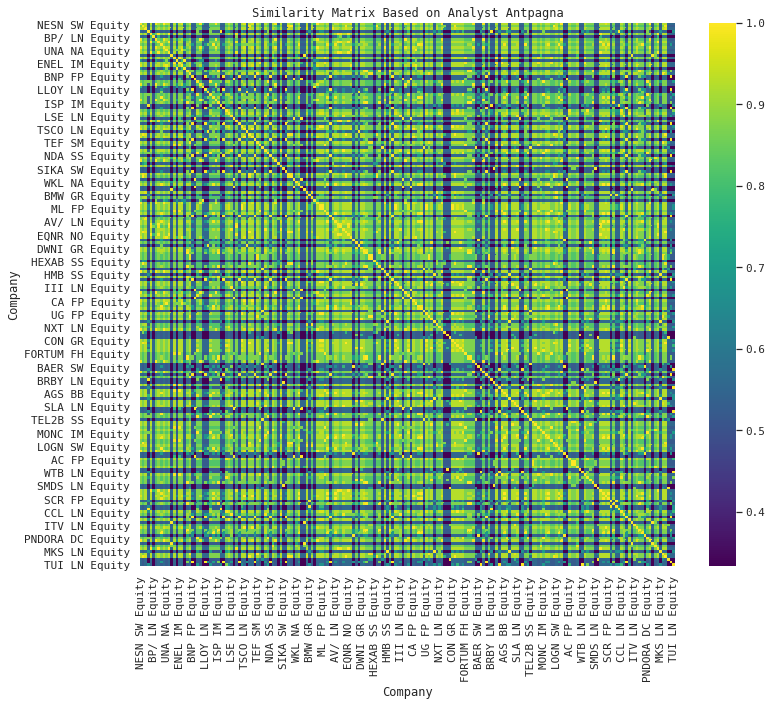

In [8]:
df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


- Companies covered by Anpagna seem to be similar to each other based on cosine similarity (>85% score), with a few exceptions
- MC FP Equity is an example of a company different from all others
- In general, companies that differ from the rest have low cosine similarity with all other companies.

### b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

1974 analysts
(360, 9)
Shape of the similarity matrix: (360, 360)


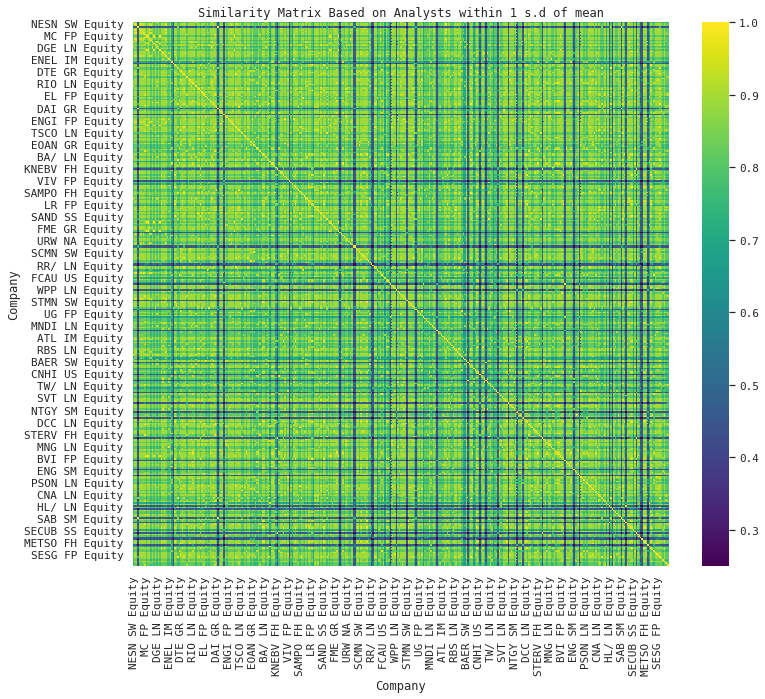

In [9]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Remove duplicates
filtered_df = filtered_df.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

print(str(len(filtered_analysts)) + " analysts")
print(filtered_df.shape)

df_preprocessed = clean_pipeline.fit_transform(filtered_df.copy())
cols = filtered_df["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analysts within 1 s.d of mean')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

- 1974 analysts remaining after the filter. 
- Companies covered seem to be generally similar to each other based on cosine similarity (>85% score), to a larger extent than analyst Antpagna.
- From this, we can understand that analyst Antpagna generally covers a wider variety of companies than most analysts.


### c. If further restricted to a smaller subset?

We take a random sample of 10 analysts that covered the median number of companies

10 analysts
(30, 9)
Shape of the similarity matrix: (30, 30)


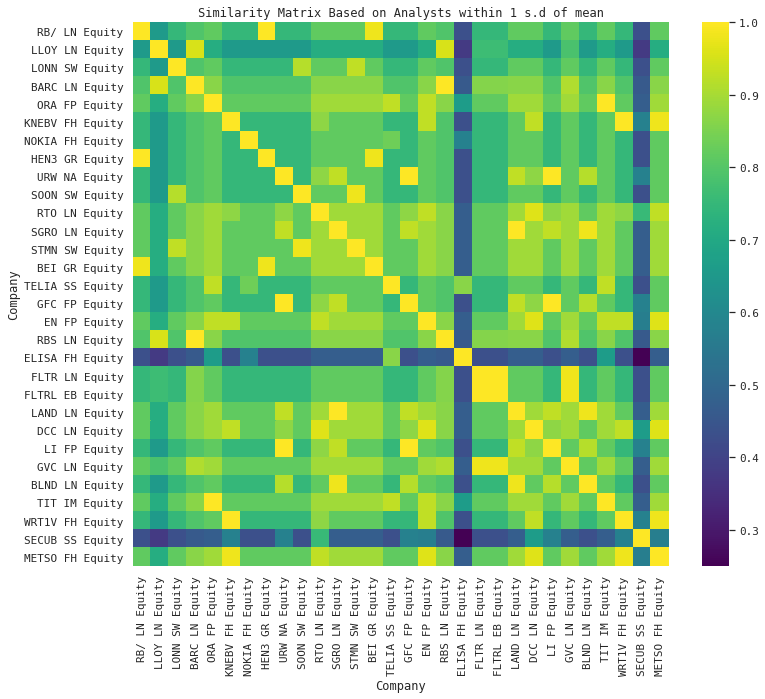

In [10]:
# Calculate the median of the number of companies covered by each analyst
median_coverage = analyst_coverage.median()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage == median_coverage)].sample(10).index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Remove duplicates
filtered_df = filtered_df.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

print(str(len(filtered_analysts)) + " analysts")
print(filtered_df.shape)

df_preprocessed = clean_pipeline.fit_transform(filtered_df.copy())
cols = filtered_df["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analysts within 1 s.d of mean')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

- We ran this test a few times, and observed that the similarity matrix does not change much
- Most companies are similar to each other based on cosine similarity, with the exception of (in this case) CLNX SM Equity, PRY IM Equity, HL/LN Equity

In [17]:
np.transpose(X_tsne)[0].std()
np.transpose(X_tsne)[1].std()

0.9040407

# 4. Which sectors are the most heterogenous? (Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

In [18]:
sectors = df_clean["GICS_SECTOR_NAME"].unique().tolist()

categorical_features_ordinal = []
categorical_features_one_hot = ['ANALYST', 'BROKER', 'BBTICKER']
numerical_features = ['RATING', 'TARGET_PRICE']

clean_pipeline = Pipeline([
    ('clean_pipeline', get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)),
    ('standard_scaler', StandardScaler()),
    ('TruncatedSVD', TruncatedSVD(n_components=5)),
    ('tsne', TSNE(n_components=2, perplexity=165, random_state=RANDOM_STATE))
])

tsne1_std = []
tsne2_std = []

for s in sectors:
    df_by_sector = df_clean[df_clean["GICS_SECTOR_NAME"] == s].copy()
    cols = df_by_sector['GICS_INDUSTRY_GROUP_NAME'].tolist()

    X_tsne = clean_pipeline.fit_transform(df_by_sector.copy())
    
    tsne1_std.append(np.transpose(X_tsne)[0].std())
    tsne2_std.append(np.transpose(X_tsne)[1].std())

    print(clean_pipeline['tsne'].kl_divergence_)

    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=cols)
    fig.update_layout(
        title="t-SNE visualization of Sector " + s,
        xaxis_title="First t-SNE",
        yaxis_title="Second t-SNE",
    )
    fig.show()



0.44594651460647583


0.3896612226963043


0.7017597556114197


0.2904362380504608


0.601615309715271


0.16068725287914276


0.6043552756309509


0.33168601989746094


0.46482592821121216


0.2574850618839264


0.05125655606389046


In [20]:
perplexity = np.arange(50, 200, 5)
divergence = []

for i in perplexity:
    clean_pipeline = Pipeline([
        ('clean_pipeline', get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)),
        ('standard_scaler', StandardScaler()),
        ('TruncatedSVD', TruncatedSVD(n_components=5)),
        ('tsne', TSNE(n_components=2, perplexity=i, random_state=RANDOM_STATE))
    ])

    df_by_sector = df_clean[df_clean["GICS_SECTOR_NAME"] == "Consumer Discretionary"].copy()

    reduced = clean_pipeline.fit_transform(df_by_sector.copy())
    divergence.append(clean_pipeline['tsne'].kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

KL Divergence start lowest at perplexity = 165, so we will use that value for above.

<Figure size 1080x720 with 0 Axes>

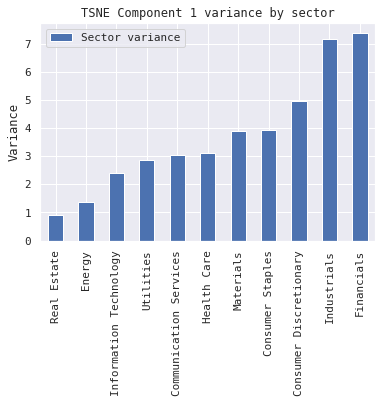

<Figure size 1080x720 with 0 Axes>

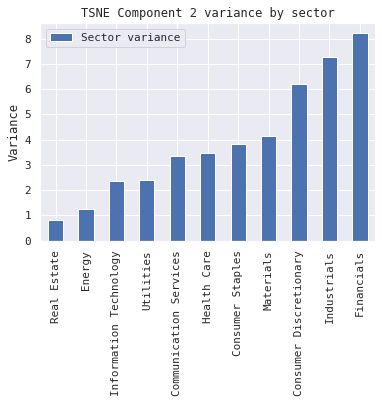

In [24]:
tsne_1 = pd.DataFrame()
tsne_2 = pd.DataFrame()

tsne_1["Sector variance"] = tsne1_std
tsne_2["Sector variance"] = tsne2_std

tsne_1.index = sectors
tsne_2.index = sectors

tsne_1 = tsne_1.sort_values(by=['Sector variance'])
tsne_2 = tsne_2.sort_values(by=['Sector variance'])

plt.figure(figsize=(15, 10))
tsne_1.plot(kind='bar')
plt.title('TSNE Component 1 variance by sector')
plt.ylabel('Variance')
plt.show()

plt.figure(figsize=(15, 10))
tsne_2.plot(kind='bar')
plt.title('TSNE Component 2 variance by sector')
plt.ylabel('Variance')
plt.show()

# 5. Similarly, which sectors are the most homogenous?

# 6. What type of companies tend to be outliers in terms of the clusters?

# 7. Feel free to explore and provide deeper insights in the structure of the clusters/network as part of the outputs.